#### 超参数定义

In [1]:
import torch

batch_size = 64 # 每个小批量的大小
learning_rate = 0.01 # 学习率
momentum = 0.5 # 动量
EPOCH = 10 # 训练轮数

#### 标准化操作

定义标准化函数，将原始图像数据每个像素值0-255转换为服从均值为0，标准差为1的分布

In [2]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

#### 数据集加载

使用Torchvision加载MNIST手写数据集

In [3]:
from torchvision import datasets

train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### 模型网络构建

使用两层卷积->激活函数->池化嵌套；最后使用全连接层进行特征提取及输出

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x  # 输出10维数据对应0-9的概率

In [6]:
model = Net()

criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr 学习率 momentum 动量

#### 训练部分

流程：梯度置零->正向传播->损失计算->反向传播->参数更新

In [7]:
def train():
    loss_sum = 0
    for _, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    return loss_sum / train_loader.__len__()

#### 推理部分

只进行正向传播

In [8]:
def test():
    correct = 0
    total = 0
    with torch.no_grad(): # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0) # 取出当前批次的总数
            correct += (predicted == labels).sum().item()
    return correct / total

#### 数据展示

EPOCH: 1 / 10    loss: 0.35629    acc on testset: 96.77%
EPOCH: 2 / 10    loss: 0.10312    acc on testset: 97.85%
EPOCH: 3 / 10    loss: 0.07738    acc on testset: 98.07%
EPOCH: 4 / 10    loss: 0.06418    acc on testset: 98.31%
EPOCH: 5 / 10    loss: 0.05626    acc on testset: 98.43%
EPOCH: 6 / 10    loss: 0.04961    acc on testset: 98.58%
EPOCH: 7 / 10    loss: 0.04595    acc on testset: 98.59%
EPOCH: 8 / 10    loss: 0.04163    acc on testset: 98.69%
EPOCH: 9 / 10    loss: 0.03788    acc on testset: 98.8%
EPOCH: 10 / 10    loss: 0.03505    acc on testset: 98.71%


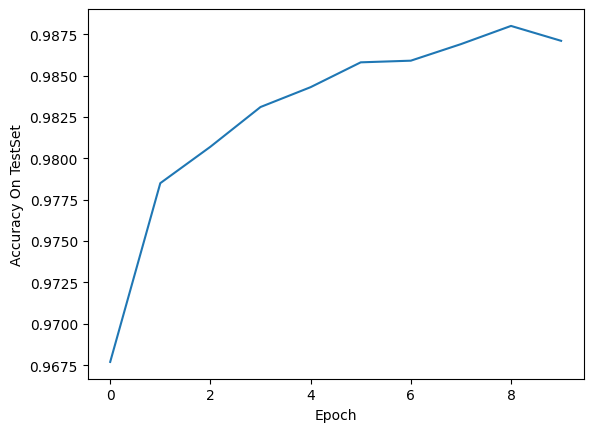

In [9]:
from matplotlib import pyplot as plt

if __name__ == '__main__':   #start
    acc_list_test = []
    for epoch in range(EPOCH):
        loss_train = train()
        acc_test = test()
        print(f"EPOCH: {epoch + 1} / {EPOCH}    loss: {round(loss_train, 5)}    acc on testset: {round(acc_test * 100, 2)}%")
        acc_list_test.append(acc_test)
 
    torch.save(model.state_dict(), "model.pth")

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()